In [90]:
import pandas as pd
import numpy as np
from datetime import date, time, datetime
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility as iv
from math import exp, sqrt, log, fabs
from statistics import mean
import matplotlib.pyplot as plt
from itertools import repeat
import os

In [54]:
work_dir = os.getcwd()
work_dir

'C:\\Users\\User\\Documents\\GitHub\\OptionStrategy'

In [55]:
def df_generate(product, date):
    # read the csv data
    csvName = product + "_" + date + '.csv'
    Path_default_readcsv = os.path.join(work_dir, 'Data', csvName)
    df = pd.read_csv(Path_default_readcsv, encoding = 'cp950')
    
    return df

In [56]:
def Flag_Moneyness(df, S, code):
    # append a column of ITM/OTM toward the put call dataframe
    if code == 'Call':
        df["Moneyness"] = ["OTM" if k > S else "ITM" for k in df["履約價"]]
    elif code == 'Put':
        df["Moneyness"] = ["OTM" if k < S else "ITM" for k in df["履約價"]]
    else:
        print("Code Type Error")
    return df

In [57]:
def todayStockPrice(date):
    product = 'MTX'
    csvName = product + "_" + date + '.csv'
    Path_default_readcsv = os.path.join(work_dir, 'Data', csvName)
    df = pd.read_csv(Path_default_readcsv, encoding = 'cp950')
    S = float(df["最後成交價"][0])
    return S

In [58]:
def IV_List(df, Stock, d, flag):
    # Write the Implied Volatility to the dataframe
    
    start_date = date(2020, int(d[1]), int(d[2:]))
    end_date = date(2020, 2, 19) # the delivery date in Feb. 
    
    S = float(Stock)
    r = 0
    q = 0
    t = np.busday_count(start_date, end_date)/252    
    
    list_IV = []
    
    #record the NA IV
    volumeNA = 0
    boundaryNA = 0
    NBBONA = 0
    for i in range(len(df)):
        if df["*一般交易時段成交量"][i] == 0: # elimanate the option with volume = 0
            list_IV.append("-")
            volumeNA += 1
        elif df["最後最佳買價"][i] == "-" or df["最後最佳賣價"][i] == "-":
            list_IV.append("-")
            NBBONA += 1
        else:
            K = float(df["履約價"][i])
            # two cases
            if flag == "Call":
                call_price = (float(df["最後最佳買價"][i]) + float(df["最後最佳賣價"][i]))/2
                intrinsic_c = fabs(max(S - K, 0.0))
                if call_price < intrinsic_c or call_price >= S: #eliminate the violation of option pricing
                    list_IV.append("-")
                    boundaryNA += 1
                else:
                    call_iv = iv(price = call_price, 
                             flag = 'c', 
                             S = Stock, 
                             K = K, 
                             t = t, 
                             r = r,
                             q = q)
                    list_IV.append(call_iv)
                    
            elif flag == "Put":
                put_price = (float(df["最後最佳買價"][i]) + float(df["最後最佳賣價"][i]))/2
                intrinsic_p = fabs(max(K - S, 0.0))
                if put_price < intrinsic_p or put_price >= K: #eliminate the violation of option pricing
                    list_IV.append("-")
                    boundaryNA += 1
                else:
                    put_iv = iv(price = put_price, 
                             flag = 'p', 
                             S = S, 
                             K = K, 
                             t = t, 
                             r = r,
                             q = q)
                    list_IV.append(put_iv)
                    
    categoryNA = [volumeNA, boundaryNA, NBBONA]
    return list_IV, categoryNA

In [59]:
def moneyness_list(S, gapType, gapNum):
    # Find out the list of OTM/ITM stock prices
    if gapType == "month":
        gap = 100
    elif gapType == "week":
        gap = 50
    else:
        print("Option Type error")
        
    S_list = []
    S_floor = int(S - S%gap)
    S_ceil = int(S_floor + gap)
    S_list.append(S_floor)
    S_list.append(S_ceil)
    
    for i in range(1, gapNum):
        S_list.append(int(S_floor - gap*i))
        S_list.append(int(S_ceil + gap*i))
    S_list.sort()
    
    return S_list

In [94]:
def plot_IV(df, S, date):
    # plot the Implied Volatility
    K = list(df["履約價"])
    IV = list(df["IV"])
    plt.style.use('ggplot')
    meanIV = mean(IV)
    plt.figure(figsize=(15,6))
    plt.plot(K, IV, marker='o')
    plt.axvline(x = S, linestyle = 'dashed', color = 'black')
    plt.text(S, meanIV, str(S))
    for a, b in zip(K, IV): 
        plt.text(a, b, str(round(b, 3)))
    title_name = "Implied Volatility_" + date
    plt.title(title_name)
    plt.xlabel('Excercise Price', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.savefig(os.path.join(work_dir, 'Graph', title_name))
    plt.show()

In [105]:
def combine_OTM(df_call, df_put, list_StockPrices):
    # cutted the dataframe and combine with certain OTM options 
    df_call_cut = df_call[df_call['履約價'].isin(list_StockPrices)]
    df_put_cut = df_put[df_put['履約價'].isin(list_StockPrices)]
    df1 = df_put_cut[df_put_cut.Moneyness == 'OTM']
    df2 = df_call_cut[df_call_cut.Moneyness == 'OTM']
    df_OTM = df1.append(df2)
    
    return df_OTM

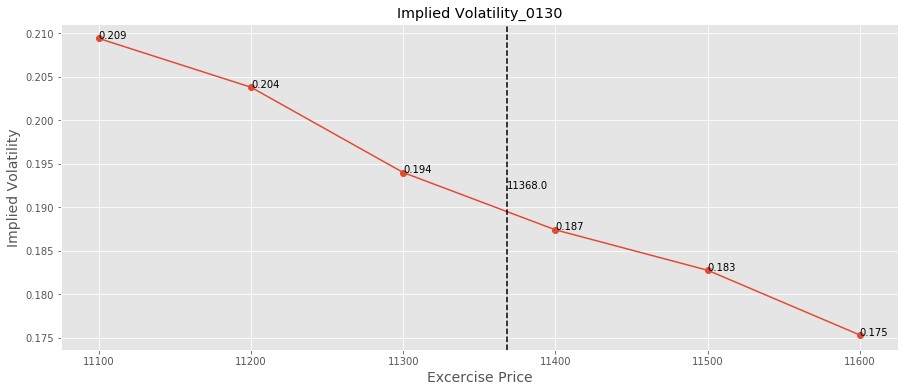

In [109]:
if __name__ ==  '__main__':
    date_ = '0130'
    S = todayStockPrice(date = date_)
    list_StockPrices = moneyness_list(S, gapType = "month", gapNum = 3) # only 3 OTM price on monthly basis
    
    # Split the df to df_call and df_put
    df = df_generate(product = 'TXO', date = date_ )
    df_put = df[df.買賣權 == 'Put'].reset_index(drop=True)
    df_call = df[df.買賣權 == 'Call'].reset_index(drop=True)
    
    # append the IV 
    df_put = Flag_Moneyness(df_put, S = S, code = 'Put')
    list_IV, categoryNAPut = IV_List(df = df_put, Stock = S, d = date_ , flag = 'Put')
    df_put["IV"] = list_IV
    
    df_call = Flag_Moneyness(df_call, S = S, code = 'Call')
    list_IV, categoryNACall = IV_List(df = df_call, Stock = S, d = date_ , flag = 'Call')
    df_call["IV"] = list_IV
    
    # Combine call and put with only OTM 
    df_OTM = combine_OTM(df_call, df_put, list_StockPrices)
    plot_IV(df = df_OTM, S = S, date = date_)
    
    

In [110]:
df_OTM

,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,最後成交價,結算價,漲跌價,...,*盤後交易時段成交量,*一般交易時段成交量,*合計成交量,*未沖銷契約量,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,Moneyness,IV
14,TXO,202002,11100,Put,25.5,113,21,112,112.0,▲+103.4,...,86,8188,8274,5704,112,113.0,160,8.3,OTM,0.209381
15,TXO,202002,11200,Put,30,142,28,142,142.0,▲+131,...,177,14622,14799,10148,140,145.0,200,10.5,OTM,0.203777
16,TXO,202002,11300,Put,43,176,37,176,176.0,▲+161,...,332,19220,19552,9265,173,176.0,232,13.5,OTM,0.193986
17,TXO,202002,11400,Call,401,401,186,186,186.0,▼-549,...,0,1912,1912,1186,181,189.0,785,186,OTM,0.187406
18,TXO,202002,11500,Call,355,359,137,137,137.0,▼-498,...,0,4694,4694,2617,137,138.0,690,137,OTM,0.182766
19,TXO,202002,11600,Call,290,290,95,97,97.0,▼-448,...,5,7539,7544,2690,94,97.0,595,95,OTM,0.175334
